In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report



讀取CSV

In [284]:
train_df = pd.read_csv("HW2_hr-analytics_train.csv")
train_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.609706,0.715803,3.803700,200.883800,3.502400,0.144400,0.02130,0.239200
std,0.247832,0.172137,1.238757,49.915824,1.478652,0.351512,0.14439,0.426616
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.00000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.00000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.00000,0.000000
75%,0.810000,0.870000,5.000000,245.000000,4.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.00000,1.000000


將數字欄位的缺失值變成NaN
經過檢查，發現沒有缺失值

In [285]:
nan_col = train_df.isna().sum()  #.isna()會回傳與train.df相同大小的datafram，若是有缺失直，就會回傳True
#.sum 就是對每個column的True數目求和


#下面兩個方法完全一樣，可以看出哪個column有缺失值
nan_isnull = train_df.isnull().any()
nan_isna = train_df.isna().any(axis = 0)  

print(nan_col)

print(nan_isna)

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
sales                    0
salary                   0
left                     0
dtype: int64
satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
promotion_last_5years    False
sales                    False
salary                   False
left                     False
dtype: bool


將非數字類型進行編碼(機器學習模型通常只能處理數字。因此，需要將非數字的資料轉換成數字，才能讓模型學習。)

#### 選擇適當的編碼方式：

類別無高低關係：使用 One-Hot Encoding。但要小心資料量大會有Curse of dimensionality


類別有高低順序之分：Ordinal Encoding

e.g. 
高中 --> 1
學士 --> 2
碩士 --> 3
博士 --> 4

類別與目標變數有強相關性：Target Encoding，跟據結果來進行encpde。但需注意資料洩漏。

In [286]:
sales_class = train_df['sales'].unique()
salary_class = train_df['salary'].unique()

print("unique classes in sales:",sales_class)
print('\n')
print("unuque classes in salary:",salary_class)

unique classes in sales: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


unuque classes in salary: ['low' 'medium' 'high']


經過上面觀察後，發現sales資料無相關性，所以使用one hot encoding
salary 資料有相關性，所以使用label encoding

In [287]:
## one hot encoding
sales_encoded = pd.get_dummies(train_df['sales'],prefix='sales')
#print("sales encoded:\n",sales_encoded.head())


## label encoding
mapping = {'low' : 0,'medium' :1,'high' : 2}
train_df['salary_encoded' ] = train_df['salary'].map(mapping)


將encoding結束的資料寫回新的csv

In [288]:
train_df = pd.concat([train_df,sales_encoded],axis = 1)#將one hot encoding的結果整合進去train_df
train_df = train_df.drop('sales',axis = 1)
train_df = train_df.drop('salary',axis = 1)
train_df.to_csv('encoded_train_data.csv',index= False)




建立Logistic Regression 模型並進行訓練。請呈現訓練後模型預測
的混淆矩陣。

In [289]:
from sklearn.metrics import confusion_matrix


train_df = pd.read_csv("encoded_train_data.csv")

#分離X以及Y
x = train_df.drop('left',axis = 1)
y = train_df['left']

#分離測試資料
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

#評估accuracy
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy:{accuracy}")

#建立混淆矩陣
conf_matrix = confusion_matrix(y_test,y_pred)
print(f"confusion matrix:\n {conf_matrix}")


class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Accuracy:0.79
confusion matrix:
 [[700  48]
 [162  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       748
           1       0.65      0.36      0.46       252

    accuracy                           0.79      1000
   macro avg       0.73      0.65      0.67      1000
weighted avg       0.77      0.79      0.77      1000



## 優化模型

### 進行 Mutual Information (MI) 分析

這種分析方法衡量各種特徵(X)對於Y的依賴程度，得分越高，表示該X對Y的貢獻大。

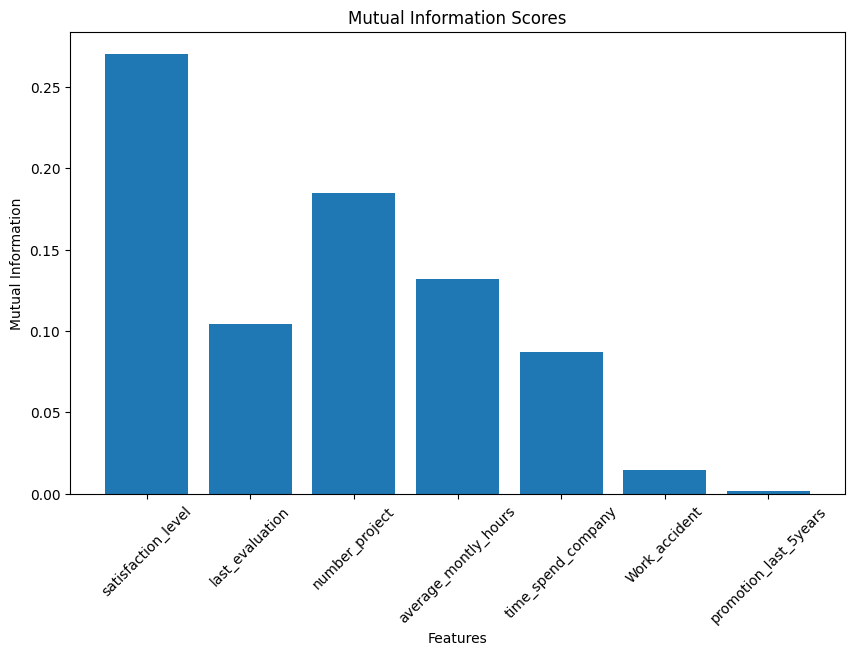

In [290]:
from sklearn.feature_selection import mutual_info_classif

# 載入資料集
df = pd.read_csv('HW2_hr-analytics_train.csv')

# 顯示資料集的資訊摘要
#print(df.info())

# 移除 `sales` 和 `salary` 欄位，因為這兩者的data type是object，而非數字
df = df.drop(['sales', 'salary'], axis=1)

# 將資料集分成特徵和目標變數
X = df.drop('left', axis=1)
y = df['left']

# 計算每個特徵與目標變數之間的互信息
mi_scores = mutual_info_classif(X, y)

# 顯示每個特徵的互信息分數
#for i, col in enumerate(X.columns):
#    print(f'{col}: {mi_scores[i]:.3f}')

import matplotlib.pyplot as plt

# 繪製長條圖
plt.figure(figsize=(10, 6))
plt.bar(X.columns, mi_scores)
plt.title('Mutual Information Scores')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45)
plt.show()

### mutual information 分析結論
promotion_last_5years 分數很低，因此考慮移除

### 進行皮爾遜相關係數分析

In [291]:
import altair as alt

# 計算皮爾遜相關係數
corr_matrix = df.corr(method='pearson')

# 建立熱圖
base = alt.Chart(corr_matrix.reset_index().melt('index')).mark_rect().encode(
    x=alt.X('index', title=''),
    y=alt.Y('variable', title=''),
    color=alt.Color('value', scale=alt.Scale(range='heatmap')),
    tooltip=['index', 'variable', 'value']
).properties(
    title='Pearson Correlation Matrix',
    width=400,   # 調整圖表寬度
    height=400   # 調整圖表高度
)

# 加入文字標籤，調整字型大小
text = base.mark_text(baseline='middle').encode(
    text=alt.Text('value', format='.2f'),
    color=alt.condition(
        alt.datum.value > 0.5,  # 當值大於 0.5 時使用深色文字
        alt.value('white'),
        alt.value('black')
    ),

)

# 合併圖表
chart = base + text

chart.display()



alt.LayerChart(...)

#### 皮爾遜解讀

用來捕捉線性關係

越接近 1 或 -1，相關性越強。

越接近 0，則表示相關性越弱，變數之間的變化沒有線性模式。

從上圖可發現，last_evaluation 以及 number project接近0，較看不出來與left的線性關係。

但這從上面MI分析來看，對Y具有一定的貢獻程度，代表他們與left可能有非線性關係

所以接下來會考慮進行分箱，可以將last_evaluation 以及 number projectc原本連續的數值，分成離散的類別。這樣就有助於Logistic Regression去學習為每個不同的類別學習不同的權重。


## 綜合調整

了解到  Logistic Regression 是一個線性模型，因此它假設x和y之間存在線性關係。
所以嘗試在進入model前，就先透過分箱捕捉一些非線性的關係，方便mode捕捉線性關係。

1. 對average_montly_hours進行標準化(因為數值較大，範圍從100~300)

2. 對last_evaluation 以及 number projectc進行分箱，分成「低」、「中」、「高」三個類別。

3. 創造新特徵 efficiency，結合 average_montly_hours 和 time_spend_company ，表示員工的「工作效率」。

4. 移除promotion_last_5years



In [292]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("encoded_train_data.csv")

# Step 1: Normalize 'average_montly_hours'
scaler = StandardScaler()
df['average_montly_hours_normalized'] = scaler.fit_transform(df[['average_montly_hours']])

# Step 2 :Binning 'last_evaluation'
df['last_evaluation_binned'] = pd.cut(df['last_evaluation'], bins=3, labels=['Low', 'Medium', 'High'])
# Bining 'number project'
df['number_project_binned'] = pd.cut(df['number_project'],bins = 3,labels = ['Low','Medium','High'])


# Step 3: Create a new feature 'efficiency'
df['efficiency'] = df['average_montly_hours'] / df['time_spend_company']

print(df[['average_montly_hours_normalized', 'last_evaluation_binned', 'number_project_binned', 'efficiency']].head())


   average_montly_hours_normalized last_evaluation_binned  \
0                        -0.959339                    Low   
1                         1.164342                   High   
2                         0.463127                   High   
3                        -1.319964                    Low   
4                         0.663474                   High   

  number_project_binned  efficiency  
0                   Low        51.0  
1                Medium        51.8  
2                Medium        44.8  
3                   Low        45.0  
4                Medium        46.8  


### 做完特徵工程後，再次訓練

In [293]:
from sklearn.metrics import roc_auc_score

# Drop original features that have been transformed or are redundant
df = df.drop(columns=['average_montly_hours', 'last_evaluation', 'number_project','promotion_last_5years'])

# Convert categorical features to dummy variables (create binary columns for 'low', 'medium', 'high')
df = pd.get_dummies(df, columns=['last_evaluation_binned', 'number_project_binned'], drop_first=True)

#print(df.head(3))

# Define feature columns and target
X = df.drop(columns=['left'])  # Assuming 'left' is the target variable
y = df['left']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")



# Make predictions and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC score: {auc_score:.2f}")


Model Accuracy: 0.87
AUC score: 0.93


### 經由特徵工程後，準確度提升到0.87

### 利用訓練後的模型預測測試資料HW2_hr-analytics_test.csv的離職情況
#### 必須先對test data 做一樣的preprocessing

In [294]:
test_df = pd.read_csv("HW2_hr-analytics_test.csv")

## one hot encoding
sales_encoded = pd.get_dummies(test_df['sales'],prefix='sales')
#print("sales encoded:\n",sales_encoded.head())

## label encoding
mapping = {'low' : 0,'medium' :1,'high' : 2}
test_df['salary_encoded' ] = test_df['salary'].map(mapping)

#丟棄原本encode前的column
test_df = pd.concat([test_df,sales_encoded],axis = 1)#將one hot encoding的結果整合進去train_df
test_df = test_df.drop('sales',axis = 1)
test_df = test_df.drop('salary',axis = 1)
test_df.to_csv('encoded_train_data.csv',index= False)

from sklearn.preprocessing import StandardScaler


# Step 1: Normalize 'average_montly_hours'
scaler = StandardScaler()
test_df['average_montly_hours_normalized'] = scaler.fit_transform(test_df[['average_montly_hours']])

# Step 2 :Binning 'last_evaluation'
test_df['last_evaluation_binned'] = pd.cut(test_df['last_evaluation'], bins=3, labels=['Low', 'Medium', 'High'])
# Bining 'number project'
test_df['number_project_binned'] = pd.cut(test_df['number_project'],bins = 3,labels = ['Low','Medium','High'])


# Step 3: Create a new feature 'efficiency'
test_df['efficiency'] = test_df['average_montly_hours'] / test_df['time_spend_company']

# Drop original features that have been transformed or are redundant
test_df = test_df.drop(columns=['average_montly_hours', 'last_evaluation', 'number_project','promotion_last_5years'])

# Convert categorical features to dummy variables (create binary columns for 'low', 'medium', 'high')
test_df = pd.get_dummies(test_df, columns=['last_evaluation_binned', 'number_project_binned'], drop_first=True)

test_df.to_csv("final_test.csv")

#### 進行預測並輸出結果成HW2_hr-analytics_test_sol.csv

In [295]:
y_pred = model.predict(test_df)

save_df = pd.DataFrame(y_pred,columns = ['left'])
print(save_df.head(5))

save_df.to_csv('HW2_hr-analytics_test_sol.csv',index =False)

   left
0     0
1     0
2     1
3     1
4     0
